# Imports

In [38]:
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import GridSearchCV

# Configs

In [39]:
INPUT_PATH = 'datasets/'
ARIMA_PATH = 'statics/arima_predict.parquet'
OUTPUT_PATH_TEST = 'results/ridge_test_predictions.parquet'
OUTPUT_PATH_TRAIN = 'results/ridge_train_predictions.parquet'

START_DATE = '2023-01-01'
END_DATE = '2023-04-30'

FEATURE_LIST = [#'ARIMA_predicts',
                # 'borough',
                
                # 'Previous_week_trip_dist',
                # 'Previous_2week_trip_dist',
                # 'Previous_day_trip_dist',

                # 'Previous_week_passenger_count',
                # 'Previous_2week_passenger_count',
                # 'Previous_day_passenger_count',

                # 'Previous_week_fare_amount',
                # 'Previous_day_fare_amount',
                # 'Previous_2week_fare_amount',

                'Previous_2week_demand',
                'Previous_week_demand', 

                'Previous_day_demand',
                'Previous_2day_demand',
                'Previous_3day_demand',
                'Previous_4day_demand',
                'Previous_5day_demand',
                'Previous_6day_demand',
                'Previous_8day_demand',
                'Previous_9day_demand',
                'Previous_10day_demand',
                'Previous_11day_demand',
                'Previous_12day_demand',
                'Previous_13day_demand',

                # 'Previous_week_extra',
                # 'Previous_2week_extra',
                # 'Previous_day_extra',
                
                # 'Previous_2week_RatecodeID',
                # 'Previous_week_RatecodeID',
                # 'Previous_day_RatecodeID',

                # 'Previous_week_congestion_surcharge',
                # 'Previous_2week_congestion_surcharge',
                # 'Previous_day_congestion_surcharge',

                # 'Day_of_month', 
                # 'Day_of_week',
                # 'Location'
                ]

TEST_START_DATE = '2023-04-01'

AUTO_TUNE = False

# Data preparation


## Load Data

In [40]:
def load_data(path, start_date: str, end_date: str):
    df = pd.read_parquet(path)
    start_date = datetime.date.fromisoformat(start_date)
    end_date = datetime.date.fromisoformat(end_date)
    filtered_df = df[(df['tpep_pickup_datetime'].dt.date >= start_date) &
                     (df['tpep_pickup_datetime'].dt.date <= end_date)]
    dataset = filtered_df.filter(items=['tpep_pickup_datetime', 'PULocationID', 'trip_distance', 'total_amount', 'passenger_count', 'fare_amount', 'extra', 
                                        'RatecodeID', 'congestion_surcharge', 'tip_amount'])
    dataset['PU_date'] = pd.to_datetime(dataset['tpep_pickup_datetime'].dt.date)
    return dataset

In [41]:
rides_df = load_data(INPUT_PATH, START_DATE, END_DATE)

In [42]:
print(f'rides dataframe shape : {rides_df.shape}')
rides_df.head()

rides dataframe shape : (12672637, 11)


,tpep_pickup_datetime,PULocationID,trip_distance,total_amount,passenger_count,fare_amount,extra,RatecodeID,congestion_surcharge,tip_amount,PU_date
0,2023-01-01 00:32:10,161,0.97,14.30,1.0,9.3,1.00,1.0,2.5,0.00,2023-01-01
1,2023-01-01 00:55:08,43,1.10,16.90,1.0,7.9,1.00,1.0,2.5,4.00,2023-01-01
2,2023-01-01 00:25:04,48,2.51,34.90,1.0,14.9,1.00,1.0,2.5,15.00,2023-01-01
3,2023-01-01 00:03:48,138,1.90,20.85,0.0,12.1,7.25,1.0,0.0,0.00,2023-01-01
4,2023-01-01 00:10:29,107,1.43,19.68,1.0,11.4,1.00,1.0,2.5,3.28,2023-01-01


In [43]:
statics_df = pd.read_parquet(ARIMA_PATH)

In [44]:
print(f'rides dataframe shape : {statics_df.shape}')
statics_df.head()

rides dataframe shape : (27772, 1)


,0
0,18
1,0
2,1
3,86
4,1


## Labeling

In [74]:
def labeling(dataset):
    dataset_labels_demand = (
        dataset
        .groupby(['PULocationID', 'PU_date'])['PU_date']
        .count()
        .to_frame('Demand')
        .sort_values(['PULocationID', 'PU_date'], ascending=[True, True])
        .reset_index()
        .rename(columns={'PULocationID': 'Location', 'PU_date': 'Date'})
    )

    dataset_labels_trip = (
        dataset
        .groupby(['PULocationID', 'PU_date'])['trip_distance']
        .sum()
        .to_frame('trip_dist_sums')
        .sort_values(['PULocationID', 'PU_date'], ascending=[True, True])
        .reset_index()
        .rename(columns={'PULocationID': 'Location', 'PU_date': 'Date'})
    )

    locations = pd.DataFrame(dataset_labels_demand['Location'].unique(), columns=['Location'])
    dates = pd.DataFrame(dataset_labels_demand['Date'].unique(), columns=['Date'])

    location_date_df = (
        locations
        .merge(dates, how='cross')
        .sort_values(['Location', 'Date'], ascending=[True, True])
        .reset_index(drop=True)
    )

    labels_df = (
        location_date_df
        .merge(dataset_labels_demand, how='left', on=['Location', 'Date'])
        .merge(dataset_labels_trip, how='left', on=['Location', 'Date'])
        .fillna(value=0)
    )

    return labels_df


In [75]:
labeled_df = labeling(rides_df)

In [76]:
print(f'labeled dataframe shape : {labeled_df.shape}')
labeled_df.head()

labeled dataframe shape : (31440, 4)


,Location,Date,Demand,trip_dist_sums
0,1,2023-01-01,40.0,36.74
1,1,2023-01-02,31.0,45.33
2,1,2023-01-03,27.0,0.54
3,1,2023-01-04,7.0,2.60
4,1,2023-01-05,15.0,68.41


## Add Feature

In [77]:
def feature_engineering(dataset, statics_df):
    dataset['Previous_day_demand'] = dataset.groupby(['Location'])['Demand'].shift(1)
    dataset['Previous_2day_demand'] = dataset.groupby(['Location'])['Demand'].shift(2)
    dataset['Previous_3day_demand'] = dataset.groupby(['Location'])['Demand'].shift(3)
    dataset['Previous_4day_demand'] = dataset.groupby(['Location'])['Demand'].shift(4)
    dataset['Previous_5day_demand'] = dataset.groupby(['Location'])['Demand'].shift(5)
    dataset['Previous_6day_demand'] = dataset.groupby(['Location'])['Demand'].shift(6)
    dataset['Previous_week_demand'] = dataset.groupby(['Location'])['Demand'].shift(7)
    dataset['Previous_8day_demand'] = dataset.groupby(['Location'])['Demand'].shift(8)
    dataset['Previous_9day_demand'] = dataset.groupby(['Location'])['Demand'].shift(9)
    dataset['Previous_10day_demand'] = dataset.groupby(['Location'])['Demand'].shift(10)
    dataset['Previous_11day_demand'] = dataset.groupby(['Location'])['Demand'].shift(11)
    dataset['Previous_12day_demand'] = dataset.groupby(['Location'])['Demand'].shift(12)
    dataset['Previous_13day_demand'] = dataset.groupby(['Location'])['Demand'].shift(13)
    dataset['Previous_2week_demand'] = dataset.groupby(['Location'])['Demand'].shift(14)


    dataset['Day_of_week'] = dataset['Date'].dt.dayofweek   
    dataset['Day_of_month'] = dataset['Date'].dt.day

    dataset = dataset.sort_values(by = ['Date', 'Location'])
    dataset['ARIMA_predicts'] = None
    start_index = len(dataset) - len(statics_df)
    end_index = len(dataset)
    dataset.iloc[start_index:end_index, dataset.columns.get_loc('ARIMA_predicts')] = statics_df
    dataset['ARIMA_predicts'] = dataset['ARIMA_predicts'].astype('float')
    dataset = dataset.sort_values(by = ['Location', 'Date'])
    
    return dataset

In [78]:
features_df = feature_engineering(labeled_df, statics_df)
features_df.dropna(inplace = True)

In [79]:
print(f'features dataframe shape : {features_df.shape}')
features_df.head()

features dataframe shape : (27772, 21)


,Location,Date,Demand,trip_dist_sums,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,...,Previous_8day_demand,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Day_of_week,Day_of_month,ARIMA_predicts
14,1,2023-01-15,19.0,1.58,7.0,21.0,8.0,9.0,4.0,14.0,...,6.0,11.0,15.0,7.0,27.0,31.0,40.0,6,15,18.0
15,1,2023-01-16,21.0,21.55,19.0,7.0,21.0,8.0,9.0,4.0,...,12.0,6.0,11.0,15.0,7.0,27.0,31.0,0,16,18.0
16,1,2023-01-17,18.0,66.24,21.0,19.0,7.0,21.0,8.0,9.0,...,14.0,12.0,6.0,11.0,15.0,7.0,27.0,1,17,19.0
17,1,2023-01-18,10.0,63.00,18.0,21.0,19.0,7.0,21.0,8.0,...,4.0,14.0,12.0,6.0,11.0,15.0,7.0,2,18,17.0
18,1,2023-01-19,9.0,0.11,10.0,18.0,21.0,19.0,7.0,21.0,...,9.0,4.0,14.0,12.0,6.0,11.0,15.0,3,19,12.0


## Split Train and Test Data

In [80]:
def train_test_splitting(dataset, TEST_START_DATE):

    train_df = dataset[dataset['Date'] < TEST_START_DATE]
    test_df = dataset[dataset['Date'] >= TEST_START_DATE]

    return train_df, test_df

In [81]:
train_df, test_df = train_test_splitting(features_df, TEST_START_DATE)

In [82]:
print(f'train dataframe shape : {train_df.shape}')
train_df.head()

train dataframe shape : (19912, 21)


,Location,Date,Demand,trip_dist_sums,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,...,Previous_8day_demand,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Day_of_week,Day_of_month,ARIMA_predicts
14,1,2023-01-15,19.0,1.58,7.0,21.0,8.0,9.0,4.0,14.0,...,6.0,11.0,15.0,7.0,27.0,31.0,40.0,6,15,18.0
15,1,2023-01-16,21.0,21.55,19.0,7.0,21.0,8.0,9.0,4.0,...,12.0,6.0,11.0,15.0,7.0,27.0,31.0,0,16,18.0
16,1,2023-01-17,18.0,66.24,21.0,19.0,7.0,21.0,8.0,9.0,...,14.0,12.0,6.0,11.0,15.0,7.0,27.0,1,17,19.0
17,1,2023-01-18,10.0,63.00,18.0,21.0,19.0,7.0,21.0,8.0,...,4.0,14.0,12.0,6.0,11.0,15.0,7.0,2,18,17.0
18,1,2023-01-19,9.0,0.11,10.0,18.0,21.0,19.0,7.0,21.0,...,9.0,4.0,14.0,12.0,6.0,11.0,15.0,3,19,12.0


In [83]:
print(f'test dataframe shape : {test_df.shape}')
test_df.head()

test dataframe shape : (7860, 21)


,Location,Date,Demand,trip_dist_sums,Previous_day_demand,Previous_2day_demand,Previous_3day_demand,Previous_4day_demand,Previous_5day_demand,Previous_6day_demand,...,Previous_8day_demand,Previous_9day_demand,Previous_10day_demand,Previous_11day_demand,Previous_12day_demand,Previous_13day_demand,Previous_2week_demand,Day_of_week,Day_of_month,ARIMA_predicts
90,1,2023-04-01,13.0,0.02,13.0,13.0,7.0,14.0,3.0,14.0,...,9.0,21.0,9.0,6.0,14.0,33.0,25.0,5,1,13.0
91,1,2023-04-02,17.0,3.82,13.0,13.0,13.0,7.0,14.0,3.0,...,15.0,9.0,21.0,9.0,6.0,14.0,33.0,6,2,13.0
92,1,2023-04-03,9.0,18.13,17.0,13.0,13.0,13.0,7.0,14.0,...,14.0,15.0,9.0,21.0,9.0,6.0,14.0,0,3,15.0
93,1,2023-04-04,12.0,0.01,9.0,17.0,13.0,13.0,13.0,7.0,...,3.0,14.0,15.0,9.0,21.0,9.0,6.0,1,4,11.0
94,1,2023-04-05,18.0,0.60,12.0,9.0,17.0,13.0,13.0,13.0,...,14.0,3.0,14.0,15.0,9.0,21.0,9.0,2,5,13.0


# Model Training

## **Ridge Regression**

### Model Tuning

In [84]:
def grid_search(model, test_parameters, train_data, cv = None, feature_list = FEATURE_LIST):
    gs = GridSearchCV(
        estimator = model, 
        param_grid = test_parameters, 
        scoring = 'neg_root_mean_squared_error', 
        cv = cv, 
        n_jobs = -1
        )
    
    gs.fit(train_data[feature_list], train_data['Demand'])
    return gs.best_params_, gs.best_score_

In [85]:
model = Ridge()
best_params, best_score = grid_search(
    model, 
    {'alpha':[0, 1, 10, 100,]},
    train_df, 
    cv = 5, 
    feature_list = FEATURE_LIST
    )

print(best_params, best_score)

{'alpha': 100} -88.81366521406218


### Prediction

In [86]:
def model_predict(model, train_data, test_data, feature_list):

    model.fit(train_data[feature_list], train_data['Demand'])


    train_predict_df  = model.predict(train_data[feature_list])
    test_predict_df  = model.predict(test_data[feature_list])

    return train_predict_df, test_predict_df

In [87]:
model = Ridge(**best_params)
train_prediction_df , test_prediction_df  = model_predict(model, train_df, test_df, FEATURE_LIST)

### Visualization

In [88]:
def add_day_of_year(data):
    data['day_year'] = 0
    start_date = data['Date'].min()

    for index, row in data.iterrows():

        curr_date = row['Date']
        day_number = (curr_date - start_date).days

        data.at[index, 'day_year'] = day_number
    return data

In [89]:
def prediction_visualization(train_data, test_data, train_prediction_df, test_prediction_df):


    train_data = add_day_of_year(train_data)
    test_data = add_day_of_year(test_data)

    predicted_train_df = train_data
    predicted_test_df = test_data
    predicted_train_df['Predicted'] = train_prediction_df
    predicted_test_df['Predicted'] = test_prediction_df

    train_data = train_data.groupby('day_year')['Demand'].sum()
    test_data = test_data.groupby('day_year')['Demand'].sum()
    predicted_train_df = predicted_train_df.groupby('day_year')['Predicted'].sum()
    predicted_test_df = predicted_test_df.groupby('day_year')['Predicted'].sum()

    plt.title('Train')
    plt.plot(train_data)
    plt.plot(predicted_train_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

    plot_length = len(test_data)
    plt.title('Test')
    plt.plot(test_data)
    plt.plot(predicted_test_df)
    plt.legend(["Real Value", "Predicted"], loc ="lower right")
    plt.show()

C:\Users\bardia\AppData\Local\Temp\ipykernel_2892\2975102461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_year'] = 0


C:\Users\bardia\AppData\Local\Temp\ipykernel_2892\2975102461.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['day_year'] = 0
C:\Users\bardia\AppData\Local\Temp\ipykernel_2892\2246591508.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predicted_train_df['Predicted'] = train_prediction_df
C:\Users\bardia\AppData\Local\Temp\ipykernel_2892\2246591508.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

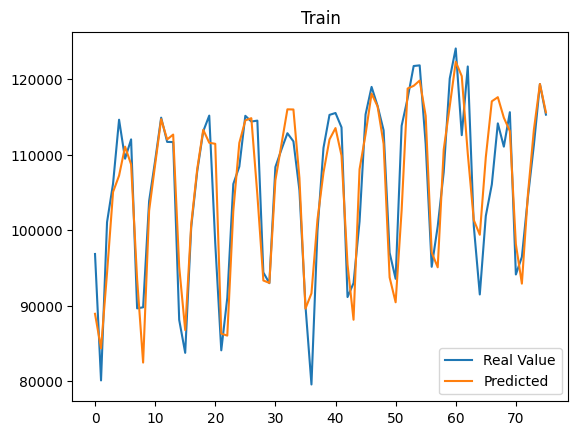

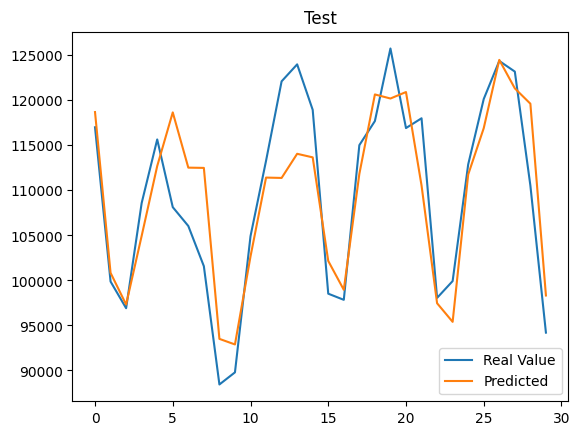

In [90]:
prediction_visualization(train_df, test_df, train_prediction_df, test_prediction_df)

### Evaluation

In [91]:
def evaluate(metric, metric_name, true_values, predicted_values):
    print(f'{metric_name} : {metric(true_values, predicted_values)}')

In [92]:
def evaluation(model_name, train_data, test_data, train_prediction_df, test_prediction_df):
    print(f'{model_name} train scores:')


    evaluate(mean_absolute_error, 'MAE', train_data['Demand'], train_prediction_df)
    evaluate(mean_squared_error, 'MSE', train_data['Demand'], train_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', train_data['Demand'], train_prediction_df)

    print(f'{model_name} test scores:')

    evaluate(mean_absolute_error, 'MAE', test_data['Demand'], test_prediction_df)
    evaluate(mean_squared_error, 'MSE', test_data['Demand'], test_prediction_df)
    evaluate(mean_absolute_percentage_error, 'MAPE', test_data['Demand'], test_prediction_df)


In [93]:
evaluation('Ridge Regression', train_df, test_df, train_prediction_df, test_prediction_df)

Ridge Regression train scores:
MAE : 28.88288575816719
MSE : 8634.014267007595
MAPE : 827077090680569.2
Ridge Regression test scores:
MAE : 29.499366508696
MSE : 7908.117514924441
MAPE : 816038994473673.1


# File Saving

In [94]:
def save_predictions(dataset, path):
    dataset.to_parquet(path, index=False)

In [95]:
def prediction_labeling(pred_df, labeled_df):
    pred_df = pd.DataFrame(pred_df, columns = ['Predicted_demand'])
    labeled_df.reset_index(inplace = True)
    labeled_prediction_df = labeled_df[['Location', 'Date']]
    labeled_prediction_df['Predicted_demand'] = pred_df
    return labeled_prediction_df

In [96]:
labeled_test_prediction_df = prediction_labeling(test_prediction_df, test_df)
labeled_train_prediction_df = prediction_labeling(train_prediction_df, train_df)

C:\Users\bardia\AppData\Local\Temp\ipykernel_2892\1857597426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_prediction_df['Predicted_demand'] = pred_df
C:\Users\bardia\AppData\Local\Temp\ipykernel_2892\1857597426.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  labeled_prediction_df['Predicted_demand'] = pred_df


In [97]:
print(f'labeled prediction dataframe shape : {labeled_test_prediction_df.shape}')
labeled_test_prediction_df.head()

labeled prediction dataframe shape : (7860, 3)


,Location,Date,Predicted_demand
0,1,2023-04-01,18.718806
1,1,2023-04-02,20.378561
2,1,2023-04-03,10.842180
3,1,2023-04-04,10.880406
4,1,2023-04-05,10.410875


In [98]:
print(f'labeled prediction dataframe shape : {labeled_train_prediction_df.shape}')
labeled_train_prediction_df.head()

labeled prediction dataframe shape : (19912, 3)


,Location,Date,Predicted_demand
0,1,2023-01-15,21.068408
1,1,2023-01-16,24.384333
2,1,2023-01-17,16.425526
3,1,2023-01-18,14.017839
4,1,2023-01-19,14.114395


In [99]:
save_predictions(labeled_train_prediction_df, OUTPUT_PATH_TRAIN)
save_predictions(labeled_test_prediction_df, OUTPUT_PATH_TEST)